In [1]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6

from pathlib import Path
from itertools import product

%matplotlib inline

@jit(nopython=True)
def compute_constellation_map_naive(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (naive implementation)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    # spectrogram dimensions
    if Y.ndim > 1:
        (K, N) = Y.shape
    else:
        K = Y.shape[0]
        N = 1
    Cmap = np.zeros((K, N), dtype=np.bool8)

    # loop over spectrogram
    for k in range(K):
        f1 = max(k - dist_freq, 0)
        f2 = min(k + dist_freq + 1, K)
        for n in range(N):
            t1 = max(n - dist_time, 0)
            t2 = min(n + dist_time + 1, N)
            curr_mag = Y[k, n]
            curr_rect = Y[f1:f2, t1:t2]
            c_max = np.max(curr_rect)
            if ((curr_mag == c_max) and (curr_mag > thresh)):
                Cmap[k, n] = True
    return Cmap

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    """Plot constellation map

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Cmap: Constellation map given as boolean mask for peak structure
        Y: Spectrogram representation (Default value = None)
        xlim: Limits for x-axis (Default value = None)
        ylim: Limits for y-axis (Default value = None)
        title: Title for plot (Default value = '')
        xlabel: Label for x-axis (Default value = 'Time (sample)')
        ylabel: Label for y-axis (Default value = 'Frequency (bins)')
        s: Size of dots in scatter plot (Default value = 5)
        color: Color used for scatter plot (Default value = 'r')
        marker: Marker for peaks (Default value = 'o')
        figsize: Width, height in inches (Default value = (7, 3))
        dpi: Dots per inch (Default value = 72)

    Returns:
        fig: The created matplotlib figure
        ax: The used axes.
        im: The image plot
    """
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=10.0):
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=duration) #changed
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann') #changed
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[1] #changed 0 -> 1
    Y = np.abs(X[:bin_max, :frame_max])


    return Y





Create a constellation map representation of the first 30 seconds of each track.

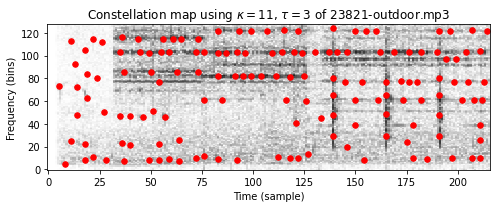

In [2]:
folder_options = ["original", "coding", "noise", "mobile", "full"] 
folder_name = folder_options[3] 
index = 12 #0-19           

files = sorted((Path("data") / folder_name).iterdir())
fn = files[index]
duration = 30 if folder_name == "full" else 10

Y = compute_spectrogram(fn, duration=duration)

dist_freq = 11  # kappa: neighborhood in frequency direction
dist_time = 3   # tau: neighborhood in time direction
title=r'Constellation map using $\kappa=%d$, $\tau=%d$ of %s' % (dist_freq, dist_time, fn.name)
Cmap_naive = compute_constellation_map_naive(Y, dist_freq, dist_time)
fig, ax, im = plot_constellation_map(Cmap_naive, np.log(1 + 1 * Y), 
                                     color='r', s=30, title=title)

Calculate different constellation map representations by exploring different settings for the parameters κ and τ.
Store the constellation maps in an appropriate format for the whole database.

In [3]:
dist_freqs = [5, 11, 21]
dist_times = [3, 7, 15]

params = list(product(dist_freqs, dist_times))

for folder_index in range(len(folder_options)):
    files = sorted((Path("data") / folder_options[folder_index]).iterdir())

    for file_index in range(20):
        fn = files[file_index]
        duration = 30 if folder_index == 4 else 10
        Y = compute_spectrogram(fn, duration=duration)

        for param_index in range(len(params)):
            dist_freq, dist_time = params[param_index]

            Cmap = compute_constellation_map_naive(Y, dist_freq, dist_time)
            coords = np.argwhere(Cmap).astype(np.int16)
            shape  = np.array(Cmap.shape, dtype=np.int32) 

            out = Path("maps") / f"f{dist_freq:02d}_t{ dist_time:02d}" / folder_options[folder_index]   
            out.mkdir(parents=True, exist_ok=True) 
            np.savez_compressed(out / f"{fn.stem}.npz", coords=coords, shape=shape)

            


In [4]:
def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    """| Compare binary matrices with tolerance
    | Note: The tolerance parameters should be smaller than the minimum distance of
      peaks (1-entries in C_ref ad C_est) to obtain meaningful TP, FN, FP values

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_ref (np.ndarray): Binary matrix used as reference
        C_est (np.ndarray): Binary matrix used as estimation
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 0)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 0)

    Returns:
        TP (int): True positives
        FN (int): False negatives
        FP (int): False positives
        C_AND (np.ndarray): Boolean mask of AND of C_ref and C_est (with tolerance)
    """
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND

In [5]:
def getMap(param_i, opt_i, file_i): 
    #param_i 0-8 
    #opt_i 0-4 (original, coding, noise, mobile, full)
    #file_i 0-19

    file = sorted((sorted(Path("maps").iterdir())[param_i] / folder_options[opt_i]).iterdir())[file_i]


    data = np.load(file)
    coords = data["coords"]
    K, N = data["shape"]

    Cmap = np.zeros((K, N), dtype=bool)
    Cmap[coords[:, 0], coords[:, 1]] = True
    return Cmap


In [7]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    """Computes matching function for constellation maps

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        C_D (np.ndarray): Binary matrix used as dababase document
        C_Q (np.ndarray): Binary matrix used as query document
        tol_freq (int): Tolerance in frequency direction (vertical) (Default value = 1)
        tol_time (int): Tolerance in time direction (horizontal) (Default value = 1)

    Returns:
        Delta (np.ndarray): Matching function
        shift_max (int): Optimal shift position maximizing Delta
    """
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max


map1 = getMap(0, 4, 15)
map2 = getMap(0, 3, 12)

print(map1.shape)
print(map2.shape)
print(compute_matching_function(map1, map2))

(128, 646)
(128, 216)
(array([27., 28., 26., 25., 23., 22., 20., 19., 22., 19., 21., 20., 24.,
       30., 24., 26., 19., 25., 22., 26., 25., 25., 23., 30., 31., 34.,
       26., 29., 26., 28., 19., 20., 19., 26., 24., 27., 24., 24., 23.,
       25., 26., 21., 23., 27., 32., 24., 25., 28., 34., 35., 31., 34.,
       27., 26., 28., 30., 32., 25., 22., 20., 21., 26., 21., 19., 18.,
       30., 34., 30., 21., 20., 23., 24., 23., 28., 30., 30., 23., 27.,
       25., 32., 25., 28., 26., 26., 28., 27., 27., 26., 27., 27., 26.,
       24., 28., 26., 26., 25., 25., 24., 31., 33., 33., 25., 22., 25.,
       32., 36., 37., 28., 30., 28., 33., 33., 34., 29., 23., 24., 27.,
       34., 30., 27., 25., 23., 26., 21., 24., 27., 27., 30., 25., 27.,
       19., 19., 21., 26., 25., 26., 25., 28., 29., 31., 30., 24., 25.,
       29., 33., 28., 22., 22., 24., 27., 24., 25., 30., 30., 31., 25.,
       26., 24., 25., 27., 28., 31., 31., 33., 36., 39., 37., 30., 36.,
       37., 37., 27., 25., 27., 31., 30.,